# Introduction

Ce notebook en contient deux en un :
1. Une partie qui s'exécute depuis un cluster EMR AWS, qui va récupérer des images pour les vectoriser. Puis, on exécute une ACP dont on sauvegarde la sortie et le modèle associé dans S3.
2. Une partie dédiée à la data visualisation, qui, elle, est exécutée depuis mon IDE local que j'ai connecté à AWS S3 pour pouvoir récupérer les elements précédemment générés.


# -- AWS EXECUTION --

# Code existant : Spark CNN

Ce code est extrait du Notebook fournit par le stagiaire. Il permet le traitement des images via le modèle MobileNetV2 et sauvegarde les vecteurs des images dans le bucket S3 qu'on a configuré

In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1691136216960_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1691136216960_0002,pyspark,idle,Link,Link,✔


## 0. Installation des packages

Les packages nécessaires ont été installés via l'étape de **bootstrap**, à l'instanciation du serveur.

## 1. Import des librairies

In [3]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.


In [4]:
# PATH = 's3://oc-ds-p8-fruits'
# PATH_Data = PATH+'/input_pictures'
# PATH_Result = PATH+'/Results'
# print('PATH:        '+\
#       PATH+'\nPATH_Data:   '+\
#       PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
PATH = 's3://oc-ds-p8-fruits'
PATH_Data = PATH+'/reduced_input_pictures'
PATH_Result = PATH+'/results_small'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://oc-ds-p8-fruits
PATH_Data:   s3://oc-ds-p8-fruits/reduced_input_pictures
PATH_Result: s3://oc-ds-p8-fruits/results_small

## 3. Traitement des données

### 3.1. Chargement des données

In [6]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://oc-ds-p8-fru...|2023-08-04 09:19:56|  5688|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-08-04 09:19:56|  5684|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-08-04 09:19:57|  5675|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-08-04 09:19:56|  5648|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-08-04 09:19:57|  5623|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [8]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------------------+----------+
|path                                                            |label     |
+----------------------------------------------------------------+----------+
|s3://oc-ds-p8-fruits/reduced_input_pictures/Strawberry/4_100.jpg|Strawberry|
|s3://oc-ds-p8-fruits/reduced_input_pictures/Strawberry/3_100.jpg|Strawberry|
|s3://oc-ds-p8-fruits/reduced_input_pictures/Strawberry/6_100.jpg|Strawberry|
|s3://oc-ds-p8-fruits/reduced_input_pictures/Strawberry/5_100.jpg|Strawberry|
|s3://oc-ds-p8-fruits/reduced_input_pictures/Strawberry/8_100.jpg|Strawberry|
+----------------------------------------------------------------+----------+
only showing top 5 rows

None

### 3.2. Préparation du modèle

In [9]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [13]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.3. Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [14]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

### 3.4. Exécutions des actions d'extractions de features

In [15]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://oc-ds-p8-fruits/results_small

In [18]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# ACP Spark

## 0. Chargement des fichiers

Le code initiale chargeait les fichiers parquet avec un Dataframe Pandas. Il semblait plus pertinent de directement travailler dans un environnement PySpark.

In [19]:
df_source = spark.read.parquet(PATH_Result)
df_source.select('features').show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            features|
+--------------------+
|[0.0026018173, 0....|
|[0.0, 0.10768058,...|
|[0.18032743, 0.00...|
+--------------------+
only showing top 3 rows

In [20]:
df_source.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

On convertit le tableau de reels en VectorUDT pour pouvoir ensuite utiliser les librairies ML de PySpark

In [21]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

# Les données images sont converties au format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
df = df_source.withColumn('features', ud_f('features'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)

## 1. Standard Scaling

In [23]:
from pyspark.ml.feature import StandardScaler

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# # Save coordinates
# PATH_PCA_Result = PATH+'/PCA/outputs'
# PATH_PCA_Model = PATH+'/PCA/model/pca_model'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
# Save coordinates
PATH_PCA_Result = PATH+'/PCA_small/outputs'
PATH_PCA_Model = PATH+'/PCA_small/model/pca_model'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
standardizer = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")
scalerModel = standardizer.fit(df)
scaled_data = scalerModel.transform(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. PCA fit & transform

On va prendre les 10 premières composantes principales afin de pouvoir tracer une _scree plot_ un peu intéressante.

In [27]:
from pyspark.ml.feature import PCA

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
k=10
pca = PCA(k=k, inputCol="scaled_features") 
pca.setOutputCol("pca_features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PCA_769b4d22a55e

In [29]:
model = pca.fit(scaled_data)
model.getK()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10

In [30]:
output_df = model.transform(scaled_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
print("Type output PCA transform : ", type(output_df))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Type output PCA transform :  <class 'pyspark.sql.dataframe.DataFrame'>

In [32]:
output_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)

In [33]:
pca_features = output_df.select('pca_features').collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
print("Collected PCA_FEATURES caracteristiques")
print("----------------------------------------------")
print("Type : ", type(pca_features))
print("Taille : ", len(pca_features))
print("Type item[0] : ", type(pca_features[0]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Collected PCA_FEATURES caracteristiques
----------------------------------------------
Type :  <class 'list'>
Taille :  1352
Type item[0] :  <class 'pyspark.sql.types.Row'>

## 3. Save outputs

On va enregistrer les 10 premières composantes principales, de manières à pouvoir les analyser dans un environnement dédié à la visualisation

In [35]:
pca_features[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(pca_features=DenseVector([4.8833, -11.2623, -4.0529, 5.2641, 6.1703, 0.6138, -4.4603, 6.4, -1.8153, -3.1425]))

In [36]:
def transform_list_of_vect_to_df(vectlist) :
    return pd.DataFrame([[vectlist[j][0][i] for i in range(k)] for j in range(len(vectlist))])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
transform_list_of_vect_to_df(pca_features).head(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          0          1         2  ...         7         8         9
0  4.883329 -11.262274 -4.052904  ...  6.400049 -1.815293 -3.142485
1  9.396344  17.469982 -1.880944  ... -4.397777  1.215441  2.170043

[2 rows x 10 columns]

_pca features_ ce sont les coordonnées de nos points dans notre nouveau référentiel définis par les vecteurs des composantes principales. Chaque point de donnée est exprimé selon les k axes de nos CP.

In [38]:
pca_coord = transform_list_of_vect_to_df(pca_features)
pca_coord.head(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          0          1         2  ...         7         8         9
0  4.883329 -11.262274 -4.052904  ...  6.400049 -1.815293 -3.142485
1  9.396344  17.469982 -1.880944  ... -4.397777  1.215441  2.170043

[2 rows x 10 columns]

In [39]:
type(pca_coord)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>

In [40]:
pca_coord = pca_coord.rename(columns={0: "pc1", 1: "pc2", 2: "pc3", 3: "pc4", 4: "pc5", 5: "pc6", 6: "pc7", 7: "pc8", 8: "pc9", 9: "pc10"})

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
pys_pca_coord = spark.createDataFrame(pca_coord)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# Save outputs
pys_pca_coord.write.mode("overwrite").parquet(PATH_PCA_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
# Save Model
model.save(PATH_PCA_Model)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
v_explained_variance = model.explainedVariance
v_explained_variance

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([0.1169, 0.106, 0.0691, 0.0621, 0.0392, 0.0354, 0.0325, 0.0246, 0.0225, 0.0213])

---------------------------------------------------------------------------------------------------------

# -- LOCAL EXECUTION --

L'environnement PySpark AWS est peu propice à l'ajout de diverses librairies nécessaires à la visualisation, sans compter que l'interface du Jupyter Hub est bien moins léchée que l'environnement PyCharm Pro que je me suis offert. Il m'a donc semblé plus opportun de travailler la visualisation et l'analyse des résultats depuis mon IDE habituel, en établissant une communication avec AWS S3 pour récupérer les fichiers générés précédemment.

Par ailleurs, distinguer les interfaces de recueil et de processing des données me paraissait assez cohérent avec les architectures lambda.

# DATASET COMPLET

## 4. PCA Analysis

### 4.1. Récupération des donnees sur S3

In [48]:
import os

print("SPARK_HOME :", os.environ['SPARK_HOME'])
print("JAVA_HOME : ", os.environ['JAVA_HOME'])

SPARK_HOME : /opt/spark-3.2.4-bin-hadoop2.7
JAVA_HOME :  /opt/jdk/jdk1.8.0_202


#### Récupération des dataframes

In [49]:
import s3fs
import fastparquet as fp

def get_s3_parquet_data(parent_folder = "oc-ds-p8-fruits/PCA/outputs") :
    s3_ref = s3fs.S3FileSystem()
    fs_ref = s3fs.core.S3FileSystem()

    #mybucket/data_folder/serial_number=1/cur_date=20-12-2012/abcdsd0324324.snappy.parquet
    s3_parquet_path = parent_folder+"/*.parquet"
    all_paths_from_s3_parquet = fs_ref.glob(path=s3_parquet_path)

    open_connec = s3_ref.open
    #use s3fs as the filesystem
    fp_objet = fp.ParquetFile(all_paths_from_s3_parquet, open_with=open_connec)
    #convert to pandas dataframe
    df_output = fp_objet.to_pandas()
    return df_output

In [50]:
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .getOrCreate()
)

In [51]:
df_vectorized_images = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/Results")
df_vectorized_images.head(2)

,path,label,features
0,s3://oc-ds-p8-fruits/input_pictures/Watermelon...,Watermelon,"[0.01771676, 0.23936023, 0.0, 0.0, 0.5658412, ..."
1,s3://oc-ds-p8-fruits/input_pictures/Pineapple ...,Pineapple Mini,"[0.0, 4.803104, 0.021533662, 0.0, 0.0, 0.0, 0...."


In [52]:
df_pca_output = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/PCA/outputs")
df_pca_output.head(2)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,-9.920288,3.574020,-5.249853,0.772622,0.280154,10.702513,-5.622513,10.530013,2.705612,-4.760893
1,-15.101982,3.067932,-6.347238,-2.776193,1.457287,5.551213,-6.705666,13.987329,0.747148,-5.102585


### 4.2. Analyses visuelles

#### Scree Plot

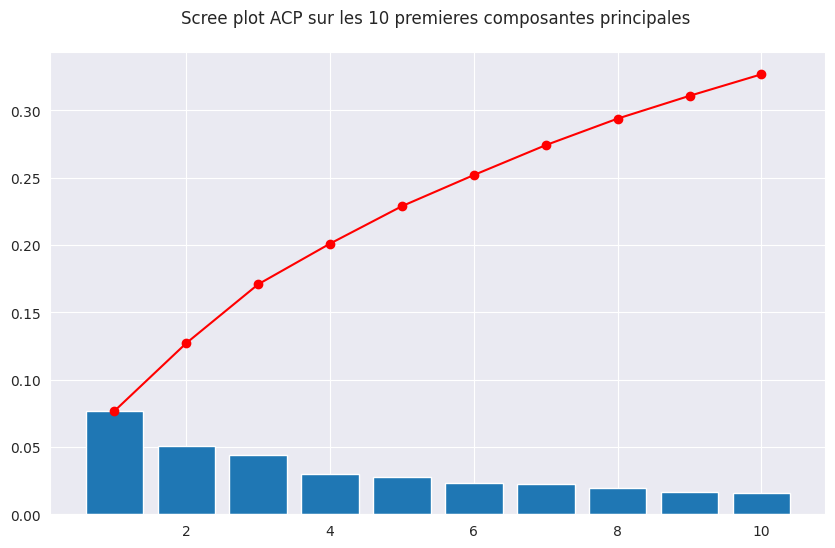

In [53]:
import matplotlib.pyplot as plt
import numpy as np
k=10
# Les valeurs ci-apres ont ete obtenu avec la cellule ci-dessus, lors de l'execution sur AWS.
scree_values = [0.0767, 0.0504, 0.0437, 0.0302, 0.0278, 0.0231, 0.0222, 0.0197, 0.0169, 0.016]

x_list = range(1, k+1)
plt.figure(figsize=(10, 6))
plt.bar(x_list, scree_values)
plt.plot(x_list, np.cumsum(scree_values), color='r', marker='o')
plt.title(f"Scree plot ACP sur les {k} premieres composantes principales \n")
plt.show()

Le coude semble apparaitre à 3 dimensions.

On va donc s'essayer à deux visualisations :
1. Une sur deux dimensions, car c'est simple et visuel
2. Une sur trois dimensions, car cela semble pertinent selon la scree plot ci-dessus.

#### Visualisation dans les espaces vectoriels des PC

In [54]:
df_pca_output['label'] = df_vectorized_images['label']
df_pca_output['cat_label'] = [nom.split(' ')[0] for nom in df_pca_output['label'].values]
df_pca_output.head(4)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,label,cat_label
0,-9.920288,3.574020,-5.249853,0.772622,0.280154,10.702513,-5.622513,10.530013,2.705612,-4.760893,Watermelon,Watermelon
1,-15.101982,3.067932,-6.347238,-2.776193,1.457287,5.551213,-6.705666,13.987329,0.747148,-5.102585,Pineapple Mini,Pineapple
2,-7.166508,9.220135,-3.933361,-1.749522,3.220139,0.883008,-1.067413,3.023270,5.111882,-7.488251,Cauliflower,Cauliflower
3,-6.648804,8.462039,-4.266296,-1.550884,1.108096,1.917386,0.243583,2.594763,3.594928,-4.829534,Cauliflower,Cauliflower


In [55]:
import seaborn as sns

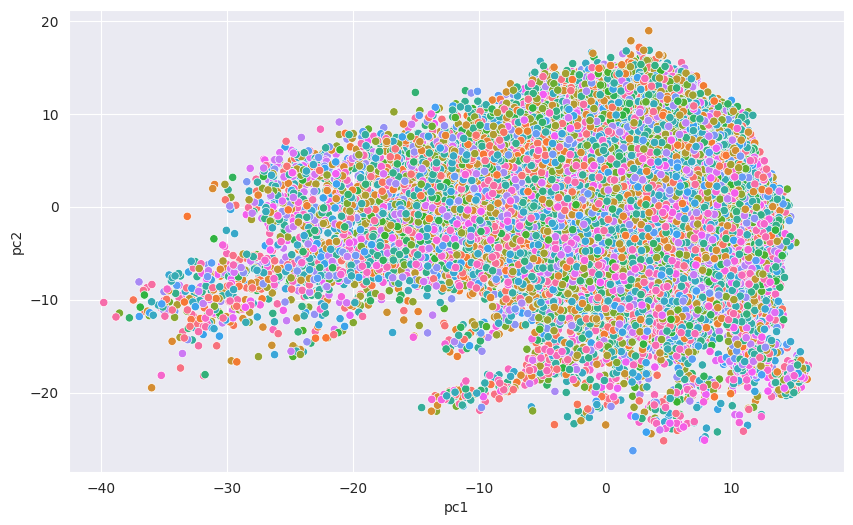

In [56]:
plt.figure(figsize=(10, 6))
g = sns.scatterplot(data=df_pca_output, x="pc1", y="pc2", hue='label')
g.legend([],[], frameon=False)
plt.show()

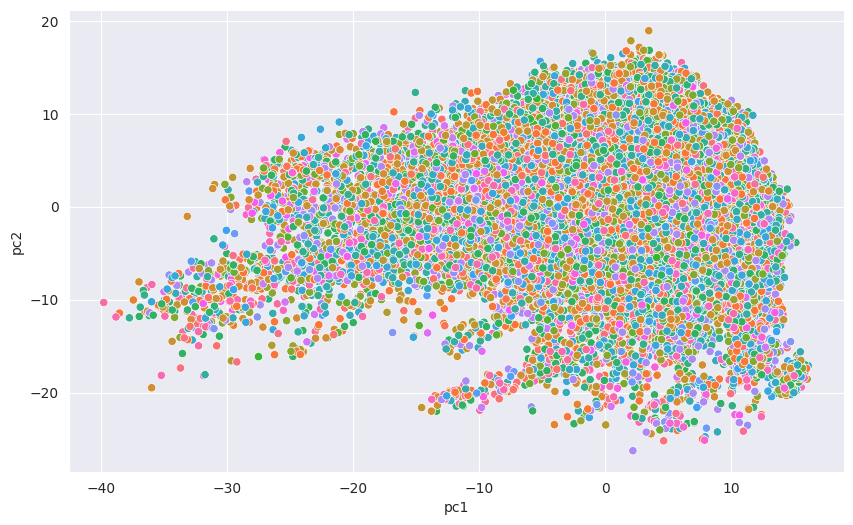

In [57]:
plt.figure(figsize=(10, 6))
g = sns.scatterplot(data=df_pca_output, x="pc1", y="pc2", hue='cat_label')
g.legend([],[], frameon=False)
plt.show()

In [58]:
import pandas as pd
df_pca_output.cat_label = pd.Categorical(df_pca_output.cat_label)
df_pca_output['code'] = df_pca_output.cat_label.cat.codes
df_pca_output.head(2)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,label,cat_label,code
0,-9.920288,3.574020,-5.249853,0.772622,0.280154,10.702513,-5.622513,10.530013,2.705612,-4.760893,Watermelon,Watermelon,66
1,-15.101982,3.067932,-6.347238,-2.776193,1.457287,5.551213,-6.705666,13.987329,0.747148,-5.102585,Pineapple Mini,Pineapple,50


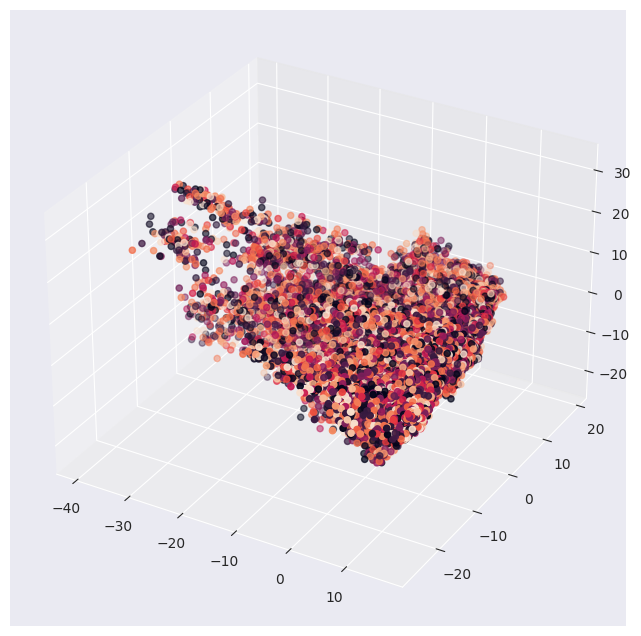

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection='3d')

zdata = df_pca_output['pc3']
xdata = df_pca_output['pc1']
ydata = df_pca_output['pc2']
ax.scatter3D(xdata, ydata, zdata,c=df_pca_output['code']);

plt.show()

L'ACP ne permet pas de visualiser clairement des clusters de fruits via les projections dans les espaces vectoriels des composantes principales. Dans la partie suivante nous allons travailler sur un jeu de données réduit afin de mieux visualiser des clusters éventuels qui seraient troublés par la masse d'informations actuelle.

<br/>
<br/>

---------------------------------------------------------------------


# Analyse approfondie du jeu de données

In [13]:
df_vectorized_images = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/Results")
df_vectorized_images.head(2)

,path,label,features
0,s3://oc-ds-p8-fruits/input_pictures/Watermelon...,Watermelon,"[0.01771676, 0.23936023, 0.0, 0.0, 0.5658412, ..."
1,s3://oc-ds-p8-fruits/input_pictures/Pineapple ...,Pineapple Mini,"[0.0, 4.803104, 0.021533662, 0.0, 0.0, 0.0, 0...."


In [15]:
df_vectorized_images['label'].nunique()

131

In [16]:
df_vectorized_images['label'].value_counts()

Grape Blue          328
Plum 3              304
Walnut              249
Cherry Rainier      246
Strawberry Wedge    246
                   ... 
Cucumber Ripe       130
Tomato Maroon       127
Mangostan           102
Pear Kaiser         102
Ginger Root          99
Name: label, Length: 131, dtype: int64

In [17]:
df_vectorized_images['cat_label'] = [nom.split(' ')[0] for nom in df_vectorized_images['label'].values]

In [18]:
df_vectorized_images['cat_label'].nunique()

67

# Travail sur un jeu de données réduit

In [60]:
import os

print("SPARK_HOME :", os.environ['SPARK_HOME'])
print("JAVA_HOME : ", os.environ['JAVA_HOME'])

SPARK_HOME : /opt/spark-3.2.4-bin-hadoop2.7
JAVA_HOME :  /opt/jdk/jdk1.8.0_202


In [61]:
import s3fs
import fastparquet as fp

def get_s3_parquet_data(parent_folder = "oc-ds-p8-fruits/PCA_outputs") :
    s3_ref = s3fs.S3FileSystem()
    fs_ref = s3fs.core.S3FileSystem()

    #mybucket/data_folder/serial_number=1/cur_date=20-12-2012/abcdsd0324324.snappy.parquet
    s3_parquet_path = parent_folder+"/*.parquet"
    all_paths_from_s3_parquet = fs_ref.glob(path=s3_parquet_path)

    open_connec = s3_ref.open
    #use s3fs as the filesystem
    fp_objet = fp.ParquetFile(all_paths_from_s3_parquet, open_with=open_connec)
    #convert to pandas dataframe
    df_output = fp_objet.to_pandas()
    return df_output

In [62]:
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .getOrCreate()
)

In [63]:
df_vectorized_images = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/results_small")
df_vectorized_images.head(2)

,path,label,features
0,s3://oc-ds-p8-fruits/reduced_input_pictures/Ap...,Apple Braeburn,"[0.3713458, 0.01086805, 0.0, 0.0, 0.0, 0.65738..."
1,s3://oc-ds-p8-fruits/reduced_input_pictures/Wa...,Walnut,"[0.07932045, 0.044467527, 0.0, 0.0, 0.93443656..."


In [64]:
df_vectorized_images.label.nunique()

8

In [65]:
df_pca_output = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/PCA_small/outputs")
df_pca_output.head(2)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,4.883329,-11.262274,-4.052904,5.264132,6.170315,0.613849,-4.460334,6.400049,-1.815293,-3.142485
1,9.396344,17.469982,-1.880944,-9.653179,8.179710,1.615890,13.465442,-4.397777,1.215441,2.170043


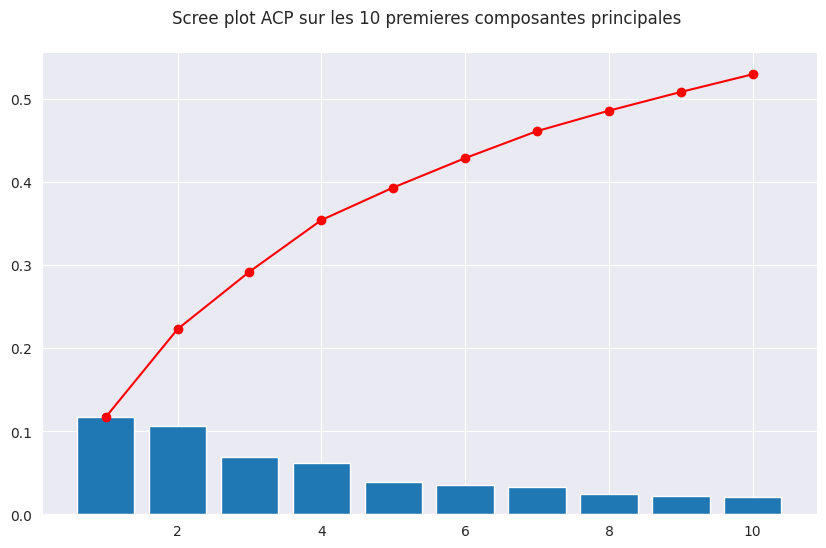

In [66]:
import matplotlib.pyplot as plt
import numpy as np
k=10
# Les valeurs ci-apres ont ete obtenu avec la cellule ci-dessus, lors de l'execution sur AWS.
scree_values = [0.1169, 0.106, 0.0691, 0.0621, 0.0392, 0.0354, 0.0325, 0.0246, 0.0225, 0.0213]

x_list = range(1, k+1)
plt.figure(figsize=(10, 6))
plt.bar(x_list, scree_values)
plt.plot(x_list, np.cumsum(scree_values), color='r', marker='o')
plt.title(f"Scree plot ACP sur les {k} premieres composantes principales \n")
plt.show()

In [67]:
df_pca_output['label'] = df_vectorized_images['label']
df_pca_output['cat_label'] = [nom.split(' ')[0] for nom in df_pca_output['label'].values]
df_pca_output.head(4)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,label,cat_label
0,4.883329,-11.262274,-4.052904,5.264132,6.170315,0.613849,-4.460334,6.400049,-1.815293,-3.142485,Apple Braeburn,Apple
1,9.396344,17.469982,-1.880944,-9.653179,8.179710,1.615890,13.465442,-4.397777,1.215441,2.170043,Walnut,Walnut
2,9.670684,16.159371,-0.785133,-10.739476,6.521588,2.366640,15.299639,-5.533511,3.357732,1.781020,Peach,Peach
3,8.164691,-6.689930,-7.394168,14.199917,-0.026165,3.965294,-2.864248,-10.169166,0.899162,5.093965,Peach,Peach


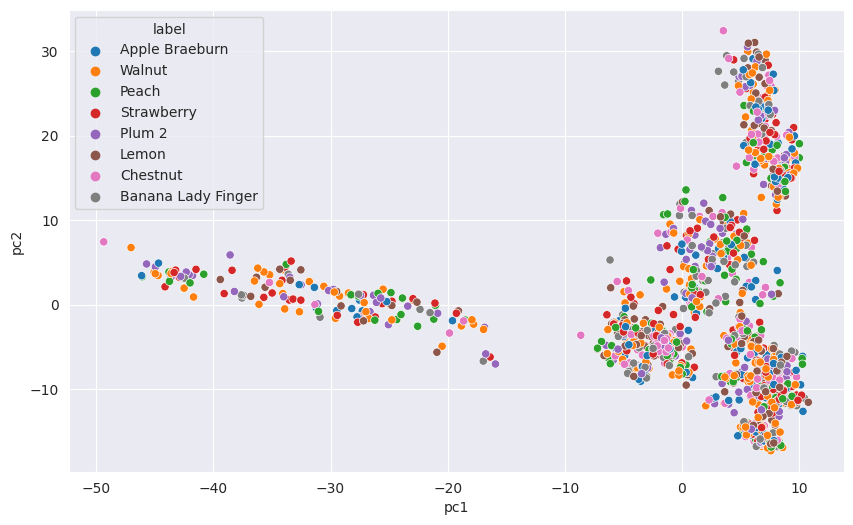

In [68]:
import seaborn as sns
plt.figure(figsize=(10, 6))
g = sns.scatterplot(data=df_pca_output, x="pc1", y="pc2", hue='label')
plt.show()

L'ACP permet de distinguer des clusters de points, mais les couleurs sont éparpillées sur ces clusters. Cette méthode de réduction de dimensions ne semble pas appropriée à notre problème.

# Visualisation via T-SNE

In [31]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initialize an empty list to store the numpy arrays
numpy_arrays = [feature for feature in df_vectorized_images['features'].values]
# Create a new DataFrame with the extracted numpy arrays
new_df = pd.DataFrame(numpy_arrays)

ss_df = pd.DataFrame(StandardScaler().fit_transform(new_df))

In [32]:
# Experimentations
from sklearn import manifold

tsne = manifold.TSNE(n_components=2)
X_trans = tsne.fit_transform(ss_df)

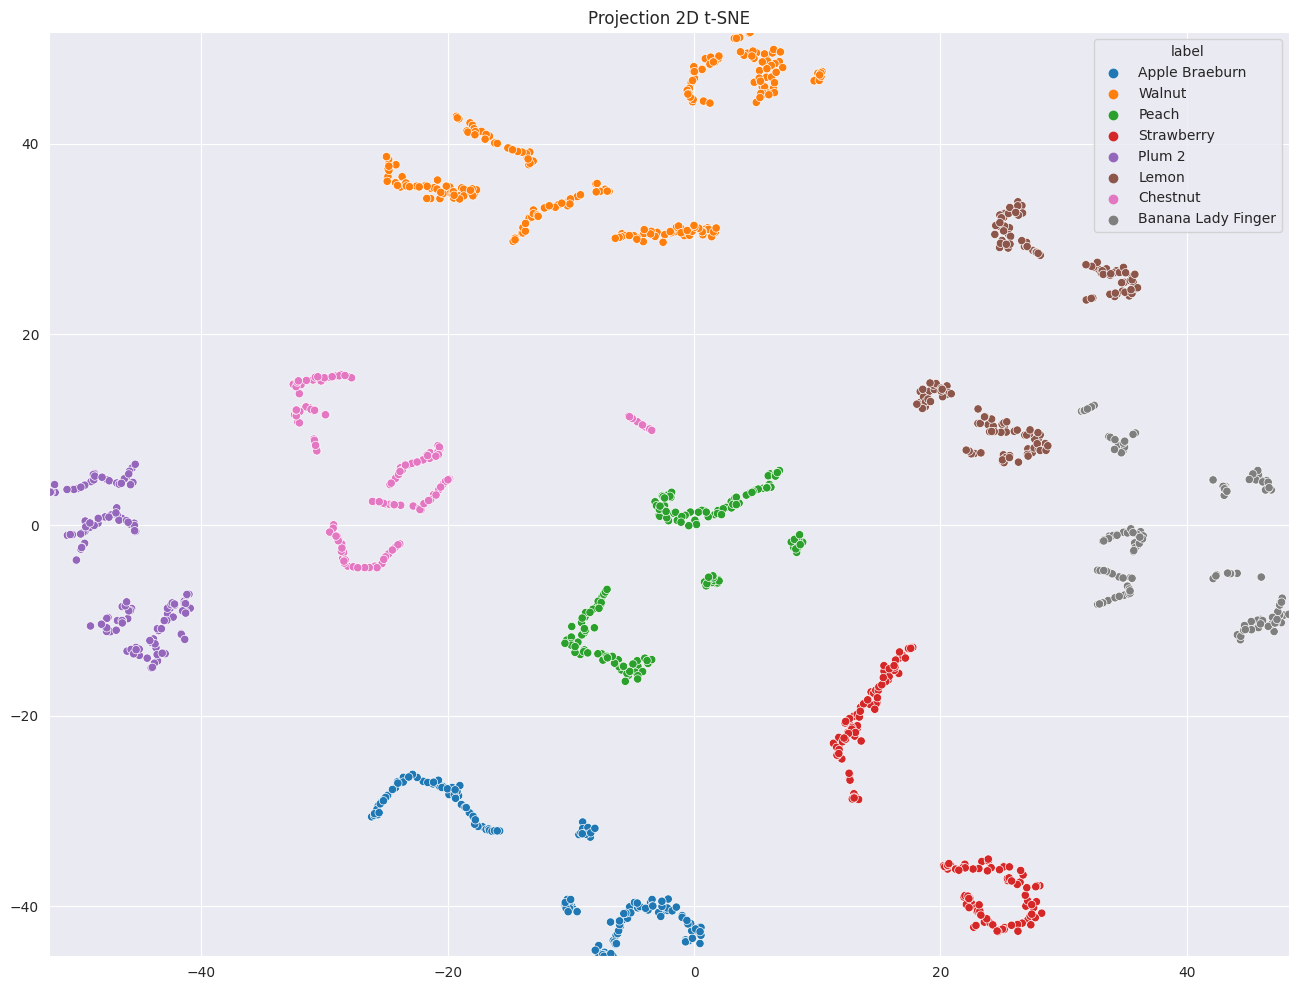

In [34]:
plt.figure(figsize=(16, 12))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=df_vectorized_images['label'])

# On redéfinit les axes pour bien voir tous les points
plt.xlim([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])])
plt.ylim([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])])

plt.title(f"Projection 2D t-SNE")

# On affiche l'image
plt.show()

t-SNE met bien en valeur des clusters de couleurs ! On peut donc bien catégoriser nos données ! Notre problème aura une solution !

Il nous faudrait :
- Voir si les résultats sont toujours aussi pertinents en augmentant le nombre de fruits dans le dataset
- Entraîner des modèles de catégorisation pour déterminé lequel est le plus approprié à notre dataset